In [1]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
from pyspark.sql.functions import sqrt, stddev, col
import math

In [2]:
spark = SparkSession.builder.appName("my App").getOrCreate()

In [3]:
df = spark.read.load("DataSample.csv",
                     format="csv", sep=",", inferSchema="true", header="true")

In [4]:
print("DF size before cleaning: %s " % df.count())
df = df.dropDuplicates([" TimeSt","Longitude","Latitude"])
print("DF size after cleaning: %s " % df.count())
df.show(10)

DF size before cleaning: 22025 
DF size after cleaning: 19999 
+-------+--------------------+-------+--------+----------+--------+----------+
|    _ID|              TimeSt|Country|Province|      City|Latitude| Longitude|
+-------+--------------------+-------+--------+----------+--------+----------+
|4609456|2017-06-21 00:04:...|     CA|      BC|  Richmond|49.18083|-123.12187|
|4642575|2017-06-21 00:07:...|     CA|      AB|  Coaldale| 49.7272|-112.57153|
|4665055|2017-06-21 00:08:...|     CA|      AB|   Calgary| 51.1467| -114.3133|
|5525837|2017-06-21 00:15:...|     CA|      ON|  Brampton| 43.7476|  -79.6912|
|4781924|2017-06-21 00:17:...|     CA|      BC|    Surrey| 49.0173|  -123.079|
|4828711|2017-06-21 00:21:...|     CA|      ON|Burlington| 43.3354|  -79.8577|
|4532616|2017-06-21 01:00:...|     CA|      ON|   Toronto| 43.6459|  -79.3857|
|5515112|2017-06-21 01:14:...|     CA|      QC|  Montréal| 45.4934|  -73.5837|
|4770360|2017-06-21 01:16:...|     CA|      AB|  Edmonton|53.44217| 

In [6]:
poi = spark.read.load("POIList.csv",
                     format="csv", sep=",", inferSchema="true", header="true")

In [7]:
poi.show()

+-----+---------+-----------+
|POIID| Latitude|  Longitude|
+-----+---------+-----------+
| POI1|53.546167|-113.485734|
| POI2|53.546167|-113.485734|
| POI3|45.521629| -73.566024|
| POI4| 45.22483| -63.232729|
+-----+---------+-----------+



In [8]:
joined_df = df.crossJoin(poi.withColumnRenamed(" Latitude", "POI_Latitude")
                         .withColumnRenamed("Longitude", "POI_Longitude"))

In [9]:
joined_df.show(10)

+-------+--------------------+-------+--------+--------+--------+----------+-----+------------+-------------+
|    _ID|              TimeSt|Country|Province|    City|Latitude| Longitude|POIID|POI_Latitude|POI_Longitude|
+-------+--------------------+-------+--------+--------+--------+----------+-----+------------+-------------+
|4609456|2017-06-21 00:04:...|     CA|      BC|Richmond|49.18083|-123.12187| POI1|   53.546167|  -113.485734|
|4609456|2017-06-21 00:04:...|     CA|      BC|Richmond|49.18083|-123.12187| POI2|   53.546167|  -113.485734|
|4609456|2017-06-21 00:04:...|     CA|      BC|Richmond|49.18083|-123.12187| POI3|   45.521629|   -73.566024|
|4609456|2017-06-21 00:04:...|     CA|      BC|Richmond|49.18083|-123.12187| POI4|    45.22483|   -63.232729|
|4642575|2017-06-21 00:07:...|     CA|      AB|Coaldale| 49.7272|-112.57153| POI1|   53.546167|  -113.485734|
|4642575|2017-06-21 00:07:...|     CA|      AB|Coaldale| 49.7272|-112.57153| POI2|   53.546167|  -113.485734|
|4642575|2

In [10]:
def distance_udf(long1,long2,lat1,lat2):
    x = long1 - long2
    y = lat1 - lat2

    dist = sqrt(x*x+y*y)

    return dist.alias("distance")
spark.udf.register("distance_udf",distance_udf)

<function __main__.distance_udf(long1, long2, lat1, lat2)>

In [11]:
distance_df = joined_df.select("_ID",
                               "Province",
                               "City",
                               "Latitude",
                               "Longitude",
                               "POIID",
                               "Latitude",
                               "POI_Longitude",
                               distance_udf(joined_df["POI_Longitude"],
                                            joined_df["Longitude"],
                                            joined_df["POI_Latitude"],
                                            joined_df["Latitude"]))

In [12]:
distance_df.show(10)

+-------+--------+--------+--------+----------+-----+--------+-------------+------------------+
|    _ID|Province|    City|Latitude| Longitude|POIID|Latitude|POI_Longitude|          distance|
+-------+--------+--------+--------+----------+-----+--------+-------------+------------------+
|4609456|      BC|Richmond|49.18083|-123.12187| POI1|49.18083|  -113.485734|10.578812983225722|
|4609456|      BC|Richmond|49.18083|-123.12187| POI2|49.18083|  -113.485734|10.578812983225722|
|4609456|      BC|Richmond|49.18083|-123.12187| POI3|49.18083|   -73.566024|  49.6907599532762|
|4609456|      BC|Richmond|49.18083|-123.12187| POI4|49.18083|   -63.232729| 60.01965632788879|
|4642575|      AB|Coaldale| 49.7272|-112.57153| POI1| 49.7272|  -113.485734|3.9268661679136643|
|4642575|      AB|Coaldale| 49.7272|-112.57153| POI2| 49.7272|  -113.485734|3.9268661679136643|
|4642575|      AB|Coaldale| 49.7272|-112.57153| POI3| 49.7272|   -73.566024| 39.23157307261687|
|4642575|      AB|Coaldale| 49.7272|-112

In [13]:
min_df = distance_df.groupBy("_ID").min("distance")

In [14]:
min_df.show(10)

+-------+--------------------+
|    _ID|       min(distance)|
+-------+--------------------+
|5509958|    6.73193262231708|
|5383790|   3.791978035912782|
|5427594| 0.13752353640377987|
|5245415|0.008228222469047468|
|5597350|  16.884670093923795|
|4881548| 0.10862129885525182|
|4983807| 0.09806816835753421|
|5058192|   2.471118548759852|
|5372830|  1.3340612187770817|
|5504815|  7.6529287078820465|
+-------+--------------------+
only showing top 10 rows



In [15]:
df1 = min_df.join(distance_df, "_ID", "left").where(min_df["min(distance)"] == distance_df["distance"]).drop("min(distance)")

In [16]:
df1.show(10)

+-------+--------+--------+--------+----------+-----+--------+-------------+-------------------+
|    _ID|Province|    City|Latitude| Longitude|POIID|Latitude|POI_Longitude|           distance|
+-------+--------+--------+--------+----------+-----+--------+-------------+-------------------+
|5193664|      AB|Edmonton|  53.587|  -113.441| POI1|  53.587|  -113.485734|0.06056785157985817|
|5193664|      AB|Edmonton|  53.587|  -113.441| POI2|  53.587|  -113.485734|0.06056785157985817|
|5398802|      AB|Edmonton|  53.587|  -113.441| POI1|  53.587|  -113.485734|0.06056785157985817|
|5398802|      AB|Edmonton|  53.587|  -113.441| POI2|  53.587|  -113.485734|0.06056785157985817|
|5344573|      AB|Edmonton|53.57904|-113.55347| POI1|53.57904|  -113.485734|0.07529143261355563|
|5344573|      AB|Edmonton|53.57904|-113.55347| POI2|53.57904|  -113.485734|0.07529143261355563|
|5041660|      AB|Edmonton|  53.585| -113.5526| POI1|  53.585|  -113.485734|0.07732440652860459|
|5041660|      AB|Edmonton|  5

In [17]:
average_df = df1.groupBy("POIID").avg("distance")

In [18]:
average_df.show()

+-----+-----------------+
|POIID|    avg(distance)|
+-----+-----------------+
| POI4|8.810410862715697|
| POI2|3.348183006325603|
| POI1|3.348183006325603|
| POI3|5.537950830488867|
+-----+-----------------+



In [19]:
stddev_df = df1.groupBy("POIID").agg(stddev("distance"))

In [20]:
stddev_df.show()

+-----+---------------------+
|POIID|stddev_samp(distance)|
+-----+---------------------+
| POI4|   28.675130269811014|
| POI2|    3.858489571570677|
| POI1|    3.858489571570677|
| POI3|   2.8586897295404907|
+-----+---------------------+



In [21]:
radius_df = df1.groupBy("POIID").max("distance")

In [22]:
radius_df.show()

+-----+------------------+
|POIID|     max(distance)|
+-----+------------------+
| POI4| 192.7049913074258|
| POI2|24.851937229893878|
| POI1|24.851937229893878|
| POI3|20.155377791591437|
+-----+------------------+



In [23]:
requests_df = df1.groupBy("POIID").count()

In [24]:
requests_df.show()

+-----+-----+
|POIID|count|
+-----+-----+
| POI4|  484|
| POI2| 9698|
| POI1| 9698|
| POI3| 9817|
+-----+-----+



In [25]:
density_join_df = requests_df.join(radius_df, "POIID")

In [26]:
density_join_df.show()

+-----+-----+------------------+
|POIID|count|     max(distance)|
+-----+-----+------------------+
| POI4|  484| 192.7049913074258|
| POI2| 9698|24.851937229893878|
| POI1| 9698|24.851937229893878|
| POI3| 9817|20.155377791591437|
+-----+-----+------------------+



In [27]:
def area_udf(count,radius):
    
    area = radius*radius*math.pi
    
    return area.alias("area")
spark.udf.register("area_udf",area_udf)

<function __main__.area_udf(count, radius)>

In [28]:
area_df = density_join_df.select("POIID","count",area_udf(density_join_df["count"], density_join_df["max(distance)"]))

In [29]:
area_df.show()

+-----+-----+------------------+
|POIID|count|              area|
+-----+-----+------------------+
| POI4|  484|116663.71447022335|
| POI2| 9698|1940.3066347803444|
| POI1| 9698|1940.3066347803444|
| POI3| 9817|1276.2382557204542|
+-----+-----+------------------+



In [30]:
density_df = area_df.withColumn("density", col("count")/col("area"))

In [31]:
density_df.show()

+-----+-----+------------------+--------------------+
|POIID|count|              area|             density|
+-----+-----+------------------+--------------------+
| POI4|  484|116663.71447022335|0.004148676408923476|
| POI2| 9698|1940.3066347803444|   4.998179064154918|
| POI1| 9698|1940.3066347803444|   4.998179064154918|
| POI3| 9817|1276.2382557204542|   7.692137385787865|
+-----+-----+------------------+--------------------+



In [32]:
ordered_density = density_df.select("density").orderBy("density",ascending=False).collect()

In [33]:
min_density = ordered_density[len(ordered_density)-1][0]
max_density = ordered_density[0][0]

In [34]:
min_density

0.004148676408923476

In [35]:
max_density

7.692137385787865

In [36]:
def popularity_udf(scale_min,scale_max,x):
    pop = (scale_max - (scale_min))*(x - min_density) / (max_density - min_density) + scale_min
    
    return pop.alias("popularity")
spark.udf.register("popularity_udf",popularity_udf)

<function __main__.popularity_udf(scale_min, scale_max, x)>

In [37]:
pop_df = density_df.select("POIID", popularity_udf(-10,10,density_df["density"]))

In [38]:
pop_df.show()

+-----+-----------------+
|POIID|       popularity|
+-----+-----------------+
| POI4|            -10.0|
| POI2|2.991773470357833|
| POI1|2.991773470357833|
| POI3|             10.0|
+-----+-----------------+



In [39]:
import pandas as pd
import matplotlib.pyplot as plt

In [41]:
p_data = pd.read_csv("DataSample.csv")

In [42]:
p_data.head()

,_ID,TimeSt,Country,Province,City,Latitude,Longitude
0,4516516,2017-06-21 00:00:00.143,CA,ON,Waterloo,43.49347,-80.49123
1,4516547,2017-06-21 18:00:00.193,CA,ON,London,42.93990,-81.27090
2,4516550,2017-06-21 15:00:00.287,CA,ON,Guelph,43.57760,-80.22010
3,4516600,2017-06-21 15:00:00.307,CA,ON,Stratford,43.37160,-80.97730
4,4516613,2017-06-21 15:00:00.497,CA,ON,Stratford,43.37160,-80.97730


In [43]:
p_poi = pd.read_csv("POIList.csv")
p_poi.head()

,POIID,Latitude,Longitude
0,POI1,53.546167,-113.485734
1,POI2,53.546167,-113.485734
2,POI3,45.521629,-73.566024
3,POI4,45.224830,-63.232729


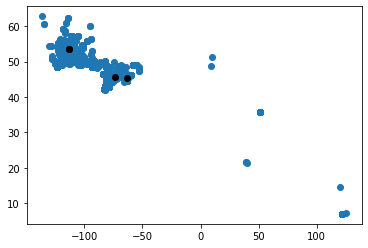

In [44]:
plt.plot(p_data["Longitude"], p_data["Latitude"],"o", p_poi["Longitude"], p_poi[" Latitude"],"ok")